In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input
import numpy as np
import matplotlib.pyplot as plt
import pathlib

In [2]:
TRAINING_DIR = "data_1/train"
VALIDATION_DIR = "data_1/test"

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    # rotation_range=40,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.2,
    # zoom_range=0.2,
    # horizontal_flip=True,
    # fill_mode='nearest',
    #validation_split=0.1
)

train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    class_mode='categorical',
                                                    batch_size=1,
                                                    target_size=(150, 150))

Found 5187 images belonging to 40 classes.


In [3]:
validation_datagen = ImageDataGenerator(
    rescale=1.0/255
)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                        class_mode='categorical',
                                                        batch_size=1,
                                                        target_size=(150, 150))


Found 1362 images belonging to 40 classes.


In [4]:
pre_trained_model = MobileNetV2(weights="imagenet", include_top=False,
                                input_tensor=Input(shape=(150, 150, 3)))

for layer in pre_trained_model.layers:
    layer.trainable = False

last_output = pre_trained_model.output


In [5]:
x = tf.keras.layers.Flatten(name="flatten")(last_output)
# x = tf.keras.layers.Dropout(0.5)(x)
# x = tf.keras.layers.Dense(32, activation="relu")(x)
x = tf.keras.layers.Dense(40, activation='softmax')(x)

model = tf.keras.models.Model(pre_trained_model.input, x)

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 75, 75, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 75, 75, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 75, 75, 32)           0         ['bn_Conv1[0][0]']        

In [6]:
int_lr = 1e-4
num_epochs = 50

optimizer = tf.optimizers.Adam(learning_rate=int_lr)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [7]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.9):
      print('accuracy and validation accuracy reach 90%')
      self.model.stop_training = True

mycallback = myCallback()

In [8]:
from sklearn.utils import class_weight
import numpy as np

class_indices = train_generator.class_indices
class_counts = np.bincount(train_generator.classes)

class_weights = class_weight.compute_class_weight('balanced',
                                                  classes=np.unique(train_generator.classes),
                                                  y=train_generator.classes)

class_weights_dict = {i: class_weights[1] for i in range(len(class_weights))}


In [10]:
H = model.fit(train_generator,
              epochs=num_epochs,
              validation_data=validation_generator,
              #class_weight=class_weights_dict,
              #callbacks=mycallback
              )


Epoch 1/50
5187/5187 [==============================] - 206s 40ms/step - loss: 0.6286 - accuracy: 0.9300 - val_loss: 6.0808 - val_accuracy: 0.5925
Epoch 2/50
5187/5187 [==============================] - 203s 39ms/step - loss: 0.5647 - accuracy: 0.9393 - val_loss: 6.6347 - val_accuracy: 0.5888
Epoch 3/50
5187/5187 [==============================] - 198s 38ms/step - loss: 0.5600 - accuracy: 0.9487 - val_loss: 6.5108 - val_accuracy: 0.6087
Epoch 4/50
5187/5187 [==============================] - 206s 40ms/step - loss: 0.5341 - accuracy: 0.9518 - val_loss: 6.9206 - val_accuracy: 0.5903
Epoch 5/50
5187/5187 [==============================] - 181s 35ms/step - loss: 0.4601 - accuracy: 0.9601 - val_loss: 7.2818 - val_accuracy: 0.5910
Epoch 6/50
5187/5187 [==============================] - 178s 34ms/step - loss: 0.5815 - accuracy: 0.9574 - val_loss: 7.1869 - val_accuracy: 0.6079
Epoch 7/50
5187/5187 [==============================] - 197s 38ms/step - loss: 0.5275 - accuracy: 0.9624 - val_loss: 7

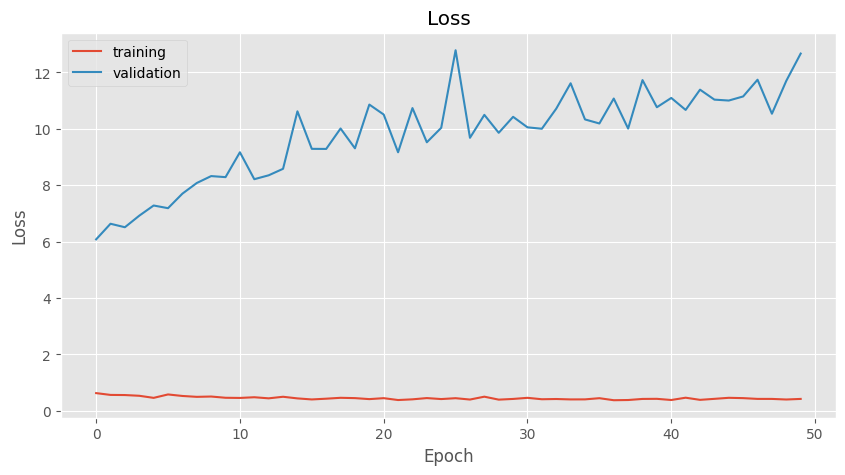

In [11]:
plt.style.use("ggplot")
plt.figure(figsize=(10, 5))
plt.plot(np.arange(0, num_epochs), H.history["loss"], label="training")
plt.plot(np.arange(0, num_epochs), H.history["val_loss"], label="validation")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()


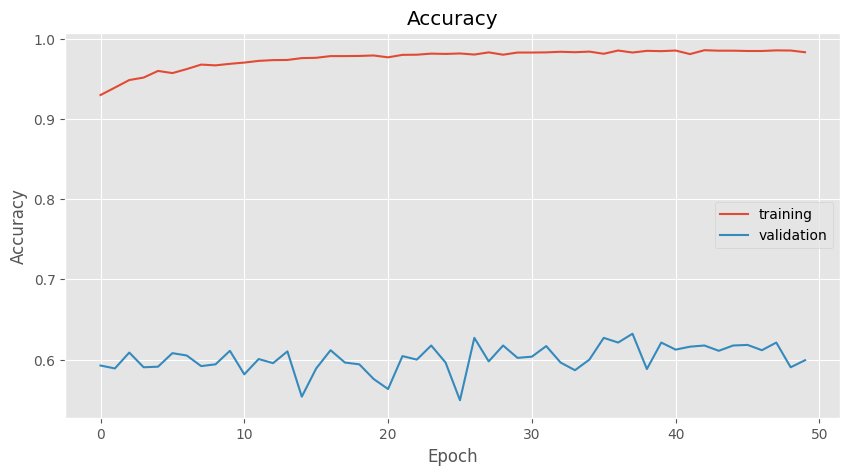

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(0, num_epochs), H.history["accuracy"], label="training")
plt.plot(np.arange(0, num_epochs), H.history["val_accuracy"], label="validation")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

## save model


In [85]:
model.save_weights('weights/weights_mobilenet-000/weights')

In [86]:
import os
model.save(os.path.join('models/h5', 'explorentt_mobilenet_v2.h5'))

c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [87]:
!tensorflowjs_converter --input_format=keras models/h5/explorentt_mobilene_v2t.h5 models/h5-tfjs


Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Scripts\tensorflowjs_converter.exe\__main__.py", line 4, in <module>
  File "C:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflowjs\__init__.py", line 21, in <module>
    from tensorflowjs import converters
  File "C:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflowjs\converters\__init__.py", line 21, in <module>
    from tensorflowjs.converters.converter import convert
  File "C:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflowjs\converters\converter.py", line 38, in <module>
    from tensorflowjs.converters import tf_saved_model_conversion_v2
  File "C:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflowjs\converters\tf_saved_model_conversion_v2.py", line 2